In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np
import pandas as pd
import yaml
from matplotlib import pyplot as plt

from analysis.dataset.june_dataset import JuNEDataset
from analysis.metrics.metrics_cells import CellsMetrics


def read_config(config_path: Path = Path("data_config.yaml")) -> dict:
    with config_path.open("r") as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError:
            return {}

config = read_config()


In [30]:
df_hack = pd.read_csv(config.get("dataset_path"), index_col=0)
df_labels = pd.read_csv(config.get("label_mapping_path"), index_col=0)
df_hack = df_hack.merge(df_labels, on='action_id')

df_hack.head()


,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,user_id,expert,cell_label
0,0,2023-05-06 10:32:26.282,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,NaN,NaN,NaN,"[\n {\n ""id"": ""35c0b3b694f84140846a21197ea...",NaN,student_7,False,NaN
1,1,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,NaN,student_7,False,helper_functions
2,2,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions
3,3,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,NaN,student_7,False,helper_functions
4,4,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions


In [32]:
june = JuNEDataset(df_hack)
june.prepare_dataset()
june.df.head()


,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,user_id,expert,cell_label,task
0,0,2023-05-06 10:32:26.282,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,None,None,None,"[\n {\n ""id"": ""35c0b3b694f84140846a21197ea...",None,student_7,False,None,task1
1,1,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,None,student_7,False,helper_functions,task1
2,2,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions,task1
3,3,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,None,student_7,False,helper_functions,task1
4,4,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions,task1


In [4]:
evolution_df = june.to_evolution_dataframe()
evolution_df


100%|██████████| 31/31 [00:28<00:00,  1.09it/s]


,state_num,cell_index,cell_num,cell_source,action_id,time,session_id,kernel_id,notebook_name,event,cell_type,cell_output,user_id,expert,cell_label,task
0,1,35c0b3b694f84140846a21197ea62f68,0.0,# # Do not forget to check if your notebook lo...,0.0,2023-05-06 10:32:26.282,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,None,None,student_7,False,None,task1
0,2,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,1.0,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,helper_functions,task1
0,3,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,2.0,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,code,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions,task1
0,4,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,3.0,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,helper_functions,task1
0,5,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,4.0,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,code,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions,task1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,497,dd4006fccad344ae8e13f2a49946b42e,14.0,"re.findall(r'[(]\S*', split2[0])[0].replace('(...",23053.0,2023-08-18 14:49:30.859,275683a9-81a4-47d8-89f0-f4f3564106bb,b12216b9-46d7-486c-9fa9-21d843da13dc,task1.ipynb,finished_execute,code,"[{""output_type"":""execute_result"",""size"":2661}]",expert_7,True,None,task1
15,497,f372fcf1d6b9403587d8f226e65df63b,15.0,"re.findall(r'\S*[d+:]\S*', split2[0])[0].repla...",23053.0,2023-08-18 14:49:30.859,275683a9-81a4-47d8-89f0-f4f3564106bb,b12216b9-46d7-486c-9fa9-21d843da13dc,task1.ipynb,finished_execute,code,"[{""output_type"":""execute_result"",""size"":2661}]",expert_7,True,None,task1
16,497,795bf5ffdb9a4bdfa5f0ed2937ea16dd,16.0,"\n\nfor i in df.iloc[:1,0]:\n split1 = i.sp...",23053.0,2023-08-18 14:49:30.859,275683a9-81a4-47d8-89f0-f4f3564106bb,b12216b9-46d7-486c-9fa9-21d843da13dc,task1.ipynb,finished_execute,code,"[{""output_type"":""execute_result"",""size"":2661}]",expert_7,True,None,task1
17,497,b5843c42fca14f1a86a780e0caaf704c,17.0,df_final = pd.DataFrame()\n\n\nfor i in df.ilo...,23053.0,2023-08-18 14:49:30.859,275683a9-81a4-47d8-89f0-f4f3564106bb,b12216b9-46d7-486c-9fa9-21d843da13dc,task1.ipynb,finished_execute,code,"[{""output_type"":""execute_result"",""size"":2661}]",expert_7,True,None,task1


In [5]:
evolution_df.shape


(557623, 16)

In [6]:
mask = (
    evolution_df.event.isin(["execute", "create", "delete", "rendered"])
)
evolution_df[mask].head()


,state_num,cell_index,cell_num,cell_source,action_id,time,session_id,kernel_id,notebook_name,event,cell_type,cell_output,user_id,expert,cell_label,task
0,2,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,1.0,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,helper_functions,task1
0,4,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,3.0,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,helper_functions,task1
0,6,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,5.0,2023-05-06 10:33:01.263,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,helper_functions,task1
0,7,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,6.0,2023-05-06 10:33:06.253,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,helper_functions,task1
0,9,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,8.0,2023-05-06 10:33:09.812,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,helper_functions,task1


In [7]:
processor = CellsMetrics()

df_tmp = evolution_df[mask]
df_tmp['event'] = 'execute'

df_analysis = processor.calculate_cell_metrics(df_tmp.iloc[:])
df_analysis.head()


/var/folders/jq/byk1x73j6pngqgl6my8tgyhm0000gn/T/ipykernel_81686/935329659.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['event'] = 'execute'
254293it [00:54, 3787.47it/s]<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
254672it [00:54, 3742.07it/s]<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13:

,state_num,cell_index,cell_num,cell_source,action_id,time,session_id,kernel_id,notebook_name,event,cell_type,cell_output,user_id,expert,cell_label,task,objects,sloc,ccn,comments
0,2,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,1.0,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,helper_functions,task1,1,2,1,0
1,4,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,3.0,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,helper_functions,task1,1,2,1,0
2,6,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,5.0,2023-05-06 10:33:01.263,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,helper_functions,task1,1,2,1,0
3,7,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,6.0,2023-05-06 10:33:06.253,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,helper_functions,task1,1,2,1,0
4,9,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,8.0,2023-05-06 10:33:09.812,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,helper_functions,task1,1,2,1,0


In [8]:
def continuous_transform(x, y, size: int = 1000, normalize: bool = True) -> tuple[np.ndarray, np.ndarray]:
    x_max = 1 if normalize else np.max(x)
    xp = np.linspace(0, x_max, size)
    x = np.linspace(0, x_max, len(y))
    y = np.array(y)

    y[np.isnan(y)] = 0
    y = np.interp(xp, x, y) + 1e-5
    return xp, y


In [9]:
import seaborn as sns
sns.reset_orig()


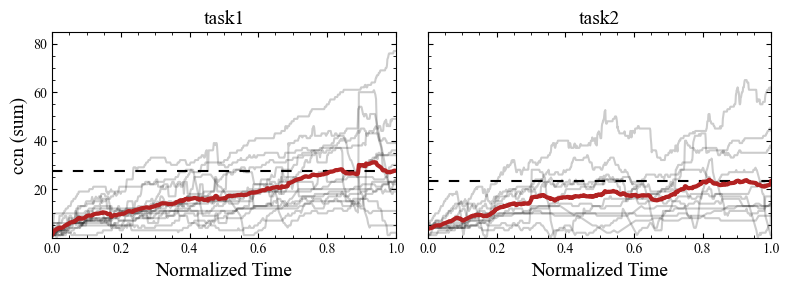

In [28]:
plt.style.use('https://github.com/klieret/simple-science-style/raw/main/stylesheets/sss1.mplstyle')
plt.rcParams["font.family"] = "Times New Roman"


_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
metric_name = 'ccn'
aggregation_function = 'sum'
task_ax_mapping = {'task1': ax1, 'task2': ax2}
mean_curve = {'task1': [], 'task2': []}

df = df_analysis
df = df[df.comments <= df.comments.quantile(0.95)]

size_threshold = 200
mn, mx = np.inf, -np.inf
for (task, kernel_id), g in df.groupby(['task', 'kernel_id']):
    if g.shape[0] < size_threshold:
        continue
    events_count = g.state_num.unique().shape[0]
    if metric_name == "cells_num":
        agg_fun_values = g.groupby("state_num").cell_index.agg('count')
        if agg_fun_values.iloc[:3].max() > 10:
            continue
    else:
        agg_fun_values = g.groupby("state_num")[metric_name].agg(aggregation_function)
        
    # if agg_fun_values.iloc[:3].max() > 10:
    #     continue

    x, y = continuous_transform(
        np.arange(events_count), agg_fun_values,
        normalize=True
    )
    mean_curve[task].append(y)

    mn = y.min() if y.min() < mn else mn
    mx = y.max() if y.max() > mx else mx

    task_ax_mapping[task].plot(x, y, color='k', alpha=0.2)

for task, curves in mean_curve.items():
    y = np.sum(curves, axis=0) / len(curves)
    x = np.linspace(0, 1, len(y))

    task_ax_mapping[task].axhline(y[-1], color='k', ls=(0, (5, 5)))
    task_ax_mapping[task].plot(x, y, color='firebrick', lw=3)

for task, ax in task_ax_mapping.items():
    ax.set_ylim(mn * 0.9, mx * 1.1)
    ax.set_xlim(0, 1)
    ax.set_xlabel('Normalized Time', fontsize=14)
    ax.set_ylabel(f"{metric_name} ({aggregation_function})", fontsize=14)
    ax.set_title(task.replace("_", " "), fontsize=14)
    ax.grid(False)


ax2.set_ylabel(None)
ax2.set_yticklabels([])
plt.tight_layout()
plt.savefig(f"figures/evolution/{metric_name}_{aggregation_function}_tasks.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [11]:
import itertools

df_tmp = df.groupby(['kernel_id', 'state_num'])[['sloc', 'ccn', 'objects']] \
    .agg(['mean', 'sum']).reset_index()

df_tmp = df_tmp.loc[df_tmp.groupby('kernel_id').state_num.idxmax()].set_index("kernel_id")
df_tmp['task'] = df_analysis[['task', 'kernel_id']] \
    .drop_duplicates(keep='last').set_index('kernel_id')['task']

df_tmp['expert'] = june.df[['expert', 'kernel_id']] \
    .drop_duplicates(keep='last').set_index('kernel_id')['expert']

df_tmp = df_tmp.reset_index()

cols = list(itertools.product(['sloc', 'ccn', 'objects'], ['mean', 'sum'], ['mean']))
table = df_tmp.drop('state_num', axis=1).groupby(["task", "expert"]).describe().loc[:, cols]
table.round(2)


/var/folders/jq/byk1x73j6pngqgl6my8tgyhm0000gn/T/ipykernel_81686/1678594950.py:16: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  table = df_tmp.drop('state_num', axis=1).groupby(["task", "expert"]).describe().loc[:, cols]


sloc          ccn        objects       
              mean    sum  mean    sum    mean    sum
              mean   mean  mean   mean    mean   mean
task  expert                                         
task1 False   2.24  77.57  0.97  41.57    1.88  74.00
      True    2.32  53.40  0.99  21.60    2.40  54.60
task2 False   4.27  87.67  0.95  19.33    4.35  83.67
      True    2.45  78.50  0.85  27.67    3.25  98.67

In [14]:
print(table.round(2).applymap('{:.2f}'.format).to_latex(escape=True, multirow=True))


\begin{tabular}{llllllll}
\toprule
 &  & \multicolumn{2}{r}{sloc} & \multicolumn{2}{r}{ccn} & \multicolumn{2}{r}{objects} \\
 &  & mean & sum & mean & sum & mean & sum \\
 &  & mean & mean & mean & mean & mean & mean \\
task & expert &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{task1} & False & 2.24 & 77.57 & 0.97 & 41.57 & 1.88 & 74.00 \\
 & True & 2.32 & 53.40 & 0.99 & 21.60 & 2.40 & 54.60 \\
\cline{1-8}
\multirow[t]{2}{*}{task2} & False & 4.27 & 87.67 & 0.95 & 19.33 & 4.35 & 83.67 \\
 & True & 2.45 & 78.50 & 0.85 & 27.67 & 3.25 & 98.67 \\
\cline{1-8}
\bottomrule
\end{tabular}


In [15]:
df_tmp = df_analysis.groupby(['kernel_id', 'state_num'])[['sloc', 'ccn', 'objects']] \
    .agg(['mean', 'sum']).reset_index()
df_tmp.columns = ['_'.join(col).strip("_") for col in df_tmp.columns.values]

df_tmp = pd.merge(
    df_tmp,
    df_analysis[['task', 'kernel_id']] \
        .drop_duplicates(keep='last')[['kernel_id', 'task']],
    on='kernel_id'
)

df_tmp = pd.merge(
    df_tmp,
    june.df[['expert', 'kernel_id']] \
        .drop_duplicates(keep='last')[['kernel_id', 'expert']],
    on='kernel_id'
)

max_values = df_tmp.groupby('kernel_id')['state_num'].transform('max')
df_tmp['normalized_state'] = df_tmp['state_num'] / max_values

metrics_list = list(df_tmp)[2:-3]

df_corr = df_tmp.groupby(['task', 'expert'])[['normalized_state', *metrics_list]].corr()
indices = [i for i in df_corr.index if i[-1] == 'normalized_state']
df_corr[metrics_list] = df_corr[metrics_list]

table = df_corr.loc[indices][metrics_list]
table.round(3)


sloc_mean  sloc_sum  ccn_mean  ccn_sum  \
task  expert                                                            
task1 False  normalized_state     -0.150     0.481    -0.120    0.418   
      True   normalized_state      0.063     0.665    -0.136    0.584   
task2 False  normalized_state      0.426     0.517     0.172    0.491   
      True   normalized_state      0.116     0.545    -0.005    0.526   

                               objects_mean  objects_sum  
task  expert                                              
task1 False  normalized_state        -0.092        0.524  
      True   normalized_state         0.146        0.688  
task2 False  normalized_state         0.539        0.585  
      True   normalized_state         0.476        0.667

In [16]:
print(table.round(2).applymap('{:.2f}'.format).to_latex(escape=True, multirow=True))


\begin{tabular}{lllllllll}
\toprule
 &  &  & sloc\_mean & sloc\_sum & ccn\_mean & ccn\_sum & objects\_mean & objects\_sum \\
task & expert &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{task1} & False & normalized\_state & -0.15 & 0.48 & -0.12 & 0.42 & -0.09 & 0.52 \\
\cline{2-9}
 & True & normalized\_state & 0.06 & 0.67 & -0.14 & 0.58 & 0.15 & 0.69 \\
\cline{1-9} \cline{2-9}
\multirow[t]{2}{*}{task2} & False & normalized\_state & 0.43 & 0.52 & 0.17 & 0.49 & 0.54 & 0.59 \\
\cline{2-9}
 & True & normalized\_state & 0.12 & 0.55 & -0.00 & 0.53 & 0.48 & 0.67 \\
\cline{1-9} \cline{2-9}
\bottomrule
\end{tabular}


In [17]:
import pingouin as pg

alpha = 0.05
for task in ['task1', 'task2']:
    for expert in [True, False]:
        for metric in metrics_list:
            df_sample = df_tmp[(df_tmp.task == task) & (df_tmp.expert == expert)][['normalized_state', metric]]
            cor = pg.corr(df_sample.normalized_state, df_sample[metric])
            if cor['p-val'].iloc[0] > alpha:
                print(metric, task, expert, cor['r'].iloc[0].round(2), cor['p-val'].iloc[0].round(2))


ccn_mean task2 True -0.0 0.81
